In [4]:
import os
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import torchvision
from torchvision.datasets import CIFAR10
from collections import OrderedDict
import torch
from clip import clip

In [2]:
descriptions = {
    "airplane": "a high-angle view of an airplane flying in the sky",
    "automobile": "a side profile of a sleek, modern automobile",
    "bird": "a colorful bird perched on a tree branch",
    "cat": "a close-up of a cute and fluffy cat",
    "deer": "a graceful deer standing in a forest clearing",
    "dog": "a playful dog with a ball in its mouth",
    "frog": "a vibrant green frog in a pond",
    "horse": "a majestic horse galloping in a field",
    "ship": "a large ship sailing on calm waters",
    "truck": "a powerful truck on a city street"
}

In [5]:
# 仅加载CIFAR-10测试集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224), antialias=True),
    # Add other transforms as needed
])

cifar10 = torchvision.datasets.CIFAR10(root='/shareddata', train=False,download=True, transform=transform)


Files already downloaded and verified


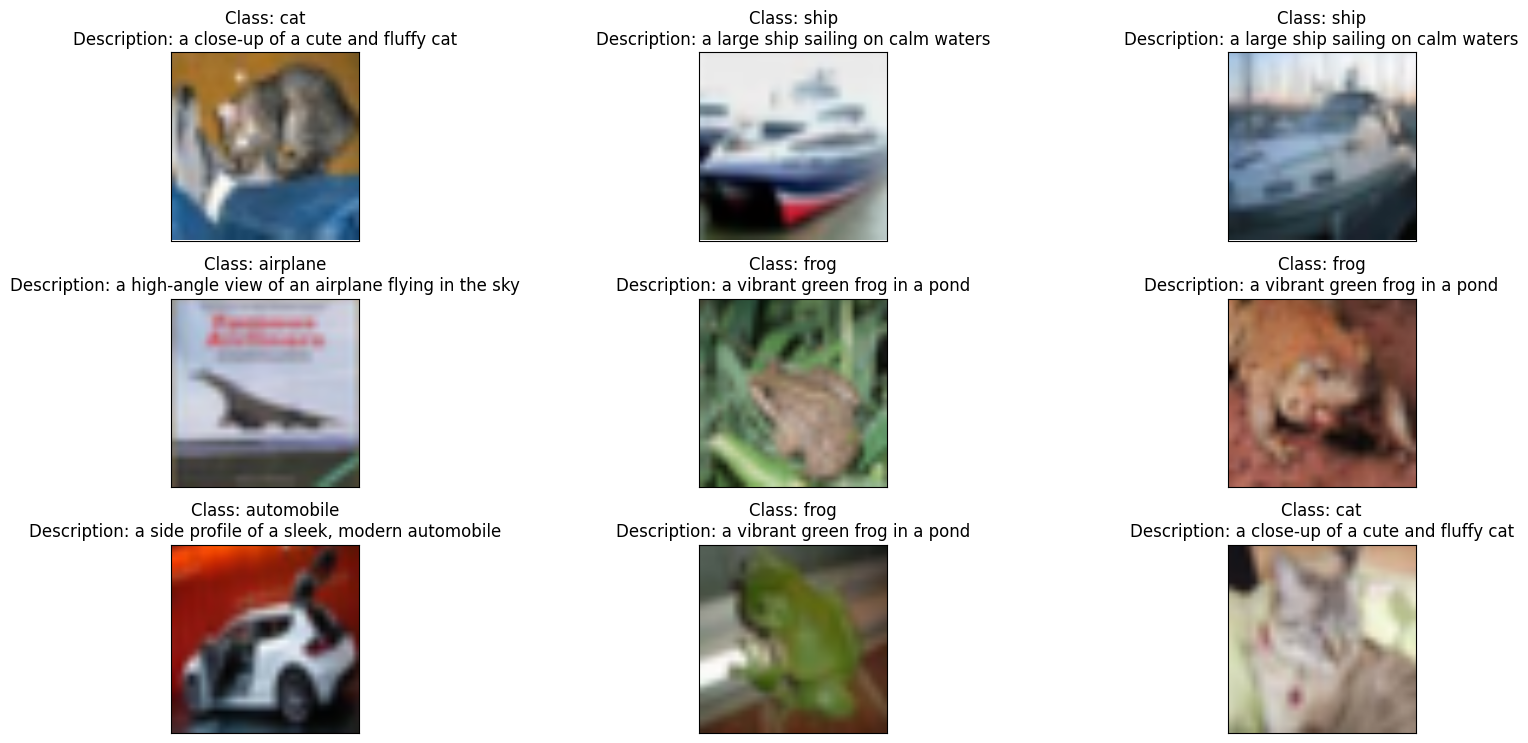

In [35]:
original_images = []
images = []
texts = []

plt.figure(figsize=(16, 10))

# Assuming you want to display the first 9 images
for i in range(9):
    image, label = cifar10[i]
    class_name = cifar10.classes[label]

    plt.subplot(4, 3, i + 1)
    plt.imshow(transforms.ToPILImage()(image))
    plt.title(f"Class: {class_name}\nDescription: {descriptions[class_name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(image)
    texts.append(descriptions[class_name])

plt.tight_layout()
plt.show()

### Building features

In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(name='ViT-B/16', device=device, download_root='/shareddata/clip/')

# Convert images to tensor and move to GPU
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

# Encode image and text features
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

### Calculating cosine similarity

In [9]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

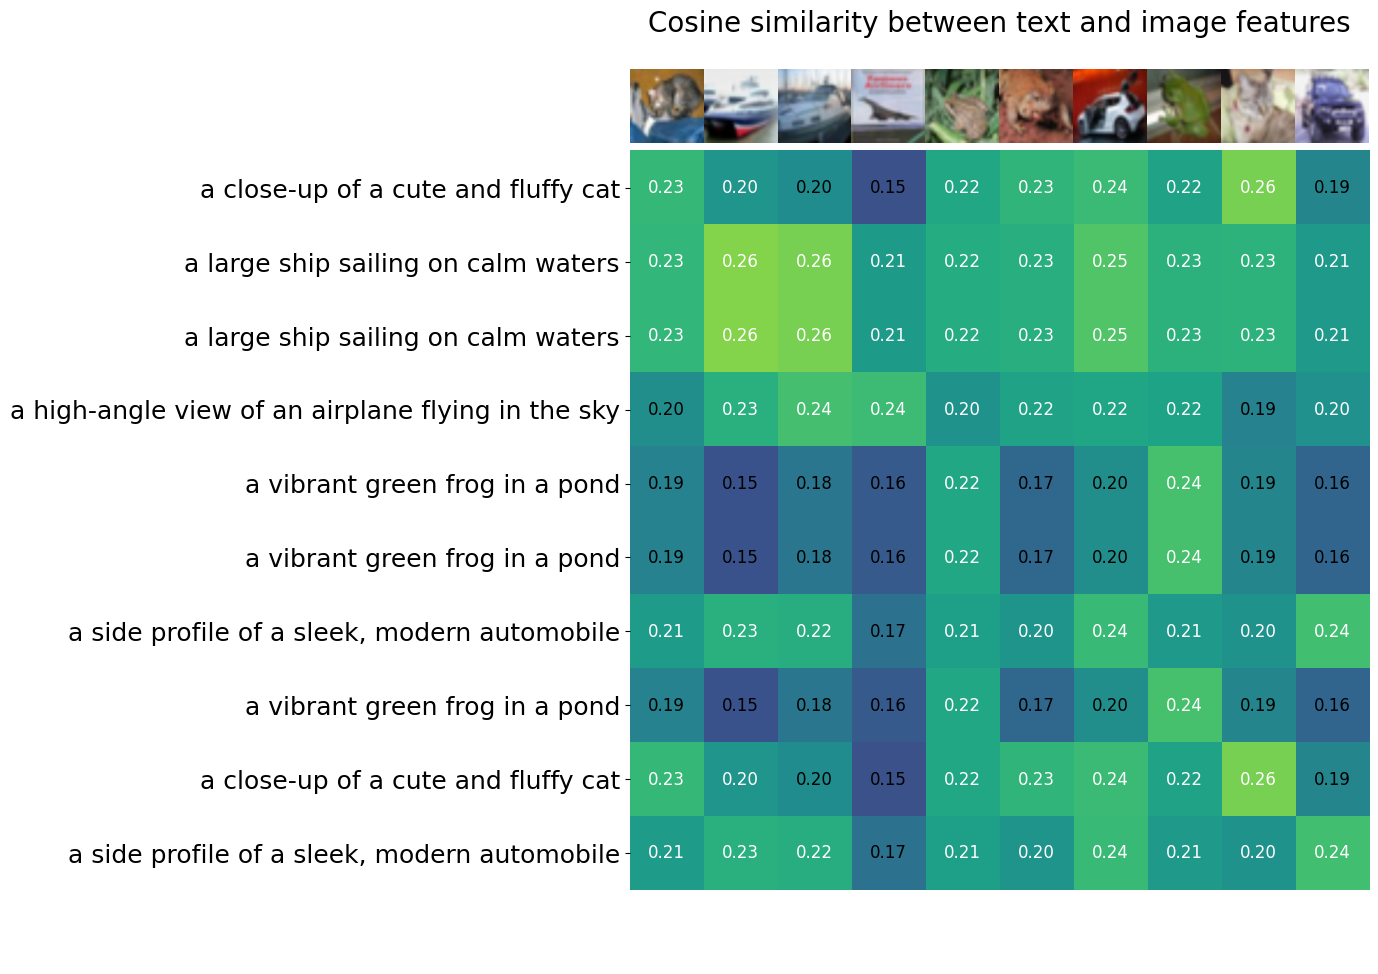

In [34]:
count = len(descriptions)
plt.figure(figsize=(18, 12))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    image_np = np.transpose(image.numpy(), (1, 2, 0))  # Convert tensor to NumPy array
    plt.imshow(image_np, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        text_color = 'white' if similarity[y, x] > 0.2 else 'black'
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12, color=text_color)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)
plt.show()


In [26]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar10.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [27]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

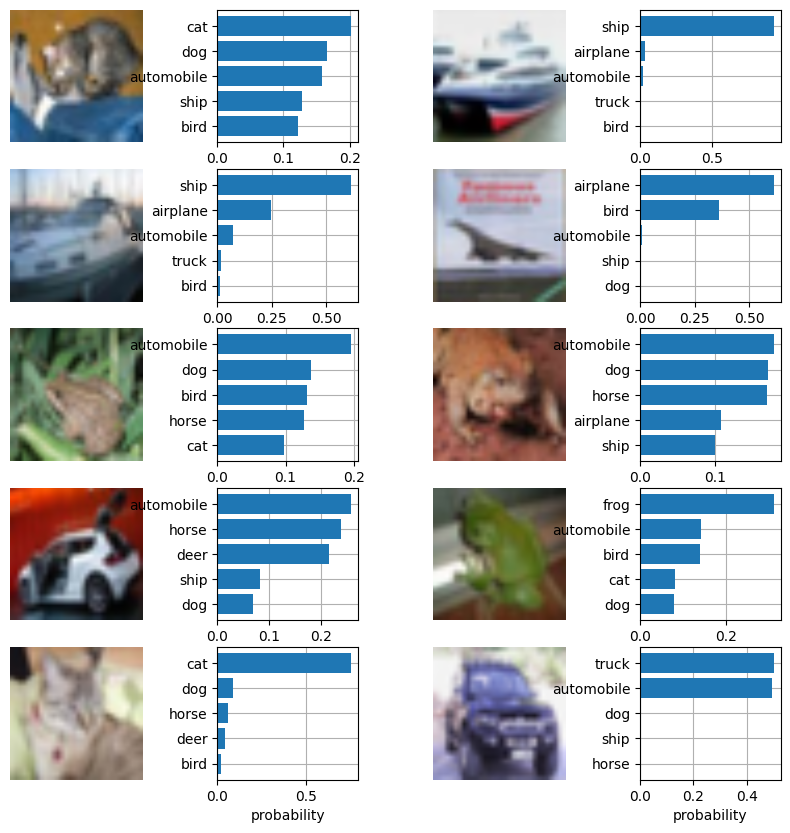

In [33]:
plt.figure(figsize=(10, 10))

for i, image in enumerate(original_images):
    plt.subplot(5, 4, 2 * i + 1)
    
    # Convert PyTorch tensor to NumPy array and transpose dimensions
    image_np = np.transpose(image.numpy(), (1, 2, 0))

    plt.imshow(image_np)
    plt.axis("off")

    plt.subplot(5, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar10.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()